## Дерево решений

Реализовать алгоритм дерева решений для бинарной классификации:

* заполнить отсутсвующие методы и реализовать простой вариант алгоритма с перебором всех признаков, всех вариантов разбиений
* Применить сортировку по признаку и делать расчеты только при изменении целевой переменной.
* реализовать и описать(!) список модификаций, которые могли бы ускорить работу дерева

В представленном ниже коде реализованы методы для выполнения предсказания вероятности и классов и для разделения выборки. По ним можно получить подсказки о возможном варианте хранения внутренней структуры дерева. Методы можно использовать, можно полностью изменить.

Проверку проделать на датасете Iris.

Ниже есть блоки кода для сравнения корректности и скорости работы с реализацией из sklearn.

Применить реализованное дерево решений для задачи Titanic на kaggle. Применить для той же задачи дерево решений из sklearn. Применить кросс-валидацию для подбора параметров. Сравнить с результатами предыдущих моделей (на кросс-валидации!). Если результат улучшился - сделать сабмит. Написать отчет о результатах.

Дополнительное задание (\*):
* реализовать разные критерии останова
* реализовать суррогатный сплит
* реализовать разбиение на любое количество узлов (параметр)


In [70]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import optimize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

%matplotlib inline

In [71]:
# Inherit out class from BaseEstimator and ClassifierMixin for compatibility with sklearn API
class MyDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    # Define constants for node types (0 - not leaf, 1 - leaf)
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None, criterion='gini'):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        
        if criterion == 'gini':
            self.G_function = self._calc_gini
        elif criterion == 'entropy':
            self.G_function = self._calc_entropy
        elif criterion == 'misclass':
            self.G_function = self._calc_misclass
        else:
            print('invalid criterion name')
            raise
            
    # Get probability for sample classes    
    def _get_probs(self, y):
        probs = np.bincount(y, minlength=self.num_class) / len(y) 

        return probs
   

    # Calculate gini impurity for sample classes
    def _calc_gini(self, y):
        probs = self._get_probs(y)
        gini = 1 - np.sum(probs**2)
        
        return gini
    
    
    # Calculate entropy for sample classes
    def _calc_entropy(self, y):
        probs = self._get_probs(y)
        if np.any(np.equal(probs, 1)):
            entropy = 0
        else:
            entropy = -np.sum(np.log2(probs) * probs)
        
        return entropy
    
    
    # Calculate misclassification error for sample classes
    def _calc_misclass(self, y):
        probs = self._get_probs(y)
        misclass = 1 - np.max(probs)
        
        return misclass
    
    # Calculate information gain for given split
    def _calc_info_gain(self, left_y, right_y):
        # Get sizes of left and right splits
        left_size = len(left_y)
        right_size = len(right_y)
        
        # Get totat size of split
        total_size = left_size + right_size
        
        # Concatenate classes of the split
        y = np.r_[left_y, right_y]
        
        # Calculate criterion before and after split
        total_criterion = self.G_function(y)
        left_criterion = self.G_function(left_y) if left_size > 0 else 0
        right_criterion = self.G_function(right_y) if right_size > 0 else 0
        
        # Calculate information gain for given criterion
        info_gain = (total_criterion - (left_size / total_size) * left_criterion
                                     - (right_size / total_size) * right_criterion)
        
        return info_gain
    
    # Sort samples and classes by given feature
    def _sort_samples(self, x, y, feature_id):
        sorted_idx = x[:, feature_id].argsort()
        
        return x[sorted_idx], y[sorted_idx]

    # Split samples and classes by given feature and split point
    def _div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] <= threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    # Get all split points for given sorted samples and classes,
    # where the value is changed.
    # Split point is chosen as the mean between chosen points
    def _get_split_points(self, sorted_x, sorted_y):
        # Generate boolean mask for indices where value is changed
        # The first value has always False value
        changed_mask = np.r_[False, (sorted_y[:-1] != sorted_y[1:])]
        
        # Get indices where value is changed (based on boolean mask)
        changed_idx = np.where(changed_mask)[0]
        
        # Get split point as the mean between different neighbor points
        split_points = (sorted_x[changed_idx] + sorted_x[changed_idx-1]) / 2
        
        # Flatten array with split points and get unique split point values
        # Split point values may have duplicates, if for any feature value 
        # there are different classes
        split_points = np.unique(split_points.ravel())
        
        return split_points

    
    # Find best split point based on maximum information gain
    def _find_threshold(self, x, y):  
        # Initialize values for searching of best split point
        best_info_gain = -1
        best_split_point = -1
        best_feature_id = -1
        
        # For each feature
        for feature_id in range(x.shape[1]):
            # Sort samples and classes based on given feature
            sorted_x, sorted_y = self._sort_samples(x, y, feature_id)
            # Calculate all split points for given feature
            split_points = self._get_split_points(sorted_x[:, feature_id], sorted_y)
            
            # For each split point
            for split_point in split_points: 
                # Split samples and classes based on given feature and split point
                left_x, right_x, left_y, right_y = self._div_samples(x, y, feature_id, split_point)
                # Calculate information gain
                info_gain = self._calc_info_gain(left_y, right_y)
                
                # If information gain is better than any previous values
                if info_gain > best_info_gain:
                    # Save information about information gain, split point and feature
                    best_split_point = split_point
                    best_feature_id = feature_id
                    best_info_gain = info_gain
            
        return best_split_point, best_feature_id
    
    # Create leaf node based on given samples, classes and node id
    def _create_leaf_node(self, x, y, node_id):
        # Get probabilites for given classes
        probs = self._get_probs(y)
        # Get predicted class as class with maximum probability
        y_class = np.argmax(probs)
        # Save node in tree with node type as leaf node in the following format:
        # (node type, predicted class, class probabilities)
        self.tree_[node_id] = (self.__class__.LEAF_TYPE,
                              y_class,
                              probs)    
    
    # Build a decision tree
    def _fit_node(self, x, y, node_id, depth):
        # Check if it is required for splitting. Stop if any of the following conditions is true:
        # 1. node is pure (criterion = 0)
        # 2. max_depth is defined and node depth is equal max_depth
        # 3. number of samples is less than min_samples_split
        no_split = ((self.G_function(y) == 0) or
                    (self.max_depth and (depth == self.max_depth)) or
                    (len(x) < self.min_samples_split))
        
        # If no split is required, create leaf node, and return
        if no_split:
            self._create_leaf_node(x, y, node_id)
            return
        
        # Otherwise, calculate best split point and feature for splitting
        split_point, feature_id = self._find_threshold(x, y)
        # Create new node with node type as non-leaf node in the following format:
        # (node type, feature id, split point)
        self.tree_[node_id] = (self.__class__.NON_LEAF_TYPE,
                              feature_id,
                              split_point)
        
        # Split samples and classes using best split point
        left_x, right_x, left_y, right_y = self._div_samples(x, y, feature_id, split_point)
        
        # Calculate ids for child nodes
        left_node_id = 2 * node_id + 1
        right_node_id = 2 * node_id + 2
        
        # Call recursively this function for left and right child nodes
        # with calculated node ids and increased depth by one
        self._fit_node(left_x, left_y, left_node_id, depth + 1)                      
        self._fit_node(right_x, right_y, right_node_id, depth + 1)
        
    # Fit training data
    def fit(self, x, y):
        self.tree_ = dict()
        
        x_arr = np.array(x)
        y_arr = np.array(y)
        # Save number of classes in the data
        self.num_class = np.unique(y).size
        # Build a decision tree beginning at root node (with node_id = 0 and depth = 0)
        self._fit_node(x_arr, y_arr, 0, 0)
        
        return self
    
    # Predict class for given sample
    def _predict_class(self, x, node_id):
        # Get node 
        node = self.tree_[node_id]
        
        # If this node is not leaf node
        if node[0] == self.__class__.NON_LEAF_TYPE:
            # Get feature and best split point from node
            _, feature_id, threshold = node
            # If feature value for the sample is less than split point
            # (Inequality sign was changed from original '>' to '<=' 
            # for more convenient comparison with sklearn implementation.
            # sklearn uses '<=' in decision tree visualizations)
            if x[feature_id] <= threshold:
                # Call recursively this function for child left node
                return self._predict_class(x, 2 * node_id + 1)
            else:
                # Otherwise, call recursively this function for child left node
                return self._predict_class(x, 2 * node_id + 2)
        else:
            # If this is leaf node, return predicted class
            return node[1]
    
    # Predict class probabilites for given sample
    def _predict_proba(self, x, node_id):
        # Get node
        node = self.tree_[node_id]
        
        # If this node is not leaf node
        if node[0] == self.__class__.NON_LEAF_TYPE:
            # Get feature and best split point from node
            _, feature_id, threshold = node
            # If feature value for the sample is less than split point
            # (Inequality sign was changed from original '>' to '<=' 
            # for more convenient comparison with sklearn implementation.
            # sklearn uses '<=' in decision tree visualizations)
            if x[feature_id] <= threshold:
                # Call recursively this function for child left node
                return self._predict_proba(x, 2 * node_id + 1)
            else:
                # Otherwise, call recursively this function for child left node
                return self._predict_proba(x, 2 * node_id + 2)
        else:
            # If this is leaf node, return class probabilities
            return node[2]
    
    # Predict classes for given samples
    def predict(self, X):
        return np.array([self._predict_class(x, 0) for x in X])
    
    # Predict class probabilities for given samples
    def predict_proba(self, X):
        return np.array([self._predict_proba(x, 0) for x in X])
    
# Fit and predict classes for given samples (commented to be compatible with sklearn API)
#     def fit_predict(self, x_train, y_train, predicted_x):
#         self.fit(x_train, y_train)
#         return self.predict(predicted_x)

Проверим работу классификатора на тестовых данных (x = [3x2], classes = [0, 1])

Samples:
[[6 3]
 [4 2]
 [7 8]]
Classes:
[1 0 0]
Tree: 
{0: (0, 0, 5.0), 1: (1, 0, array([ 1.,  0.])), 2: (0, 0, 6.5), 5: (1, 1, array([ 0.,  1.])), 6: (1, 0, array([ 1.,  0.]))}
Predict probas (my):  [[ 1.  0.]]
Predict_probas (sklearn):  [[ 1.  0.]]


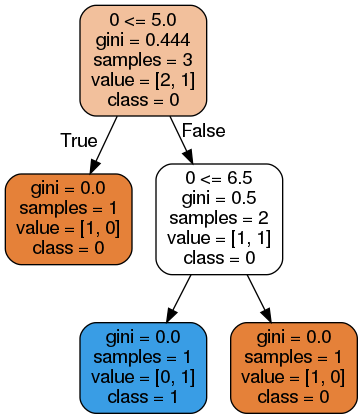

In [84]:
from pydotplus import graph_from_dot_data
from IPython.display import Image 
from sklearn.tree import export_graphviz

samples = np.array([6, 3, 4, 2, 7, 8]).reshape(3, 2)
classes = np.array([1, 0, 0])
print('Samples:')
print(samples)
print('Classes:')
print(classes)

x_test = np.array([[3, 3]])

clf = MyDecisionTreeClassifier(criterion='gini', min_samples_split=2)#, max_depth=2)
clf.fit(samples, classes)

sk_clf = DecisionTreeClassifier(criterion='gini', min_samples_split=2)#,max_depth=2)
sk_clf.fit(samples, classes)

dot_data = export_graphviz(
        sk_clf,
        out_file=None,
        feature_names=['0', '1'],
        class_names=['0', '1'],
        rounded=True,
        filled=True
    )

graph = graph_from_dot_data(dot_data)
graph.write_png('sk_tree.png')

print('Tree: ')
print(clf.tree_)
print('Predict probas (my): ', clf.predict_proba(x_test))
print('Predict_probas (sklearn): ', sk_clf.predict_proba(x_test))

Image(filename='sk_tree.png', width=600) 

На основе результатов запуска 2 классификаторов (реализованного и из sklearn), можно сделать следующие выводы:
- Т.к. в реализации sklearn есть зависимость работы классификатора от значения параметра random_state (по умолчанию он равен None, то есть при каждом запуске будет использовано свое случайное значение), то в случае, если information gain максимален для нескольких разбиений, в sklearn будут взяты различные точки разбиения при различных запусках, что может повлиять на последовательность выбранных признаков, а также даже на предсказание на новых данных
- Для наглядности, на картинке выше отображается одно из разбиений, совпадающее с нашим решением

Загрузим данные iris, и сравним точность работы 2 классификаторов (реализованного и из sklearn)
Сначала сравним классификаторы для max_depth=2

Tree: 
{0: (0, 2, 2.4500000000000002), 1: (1, 0, array([ 1.,  0.,  0.])), 2: (0, 3, 1.7), 5: (1, 1, array([ 0.        ,  0.90740741,  0.09259259])), 6: (1, 2, array([ 0.        ,  0.02173913,  0.97826087]))}
Predict probas (my):  [[ 0.          0.02173913  0.97826087]]
Predict_probas (sklearn):  [[ 0.          0.02173913  0.97826087]]


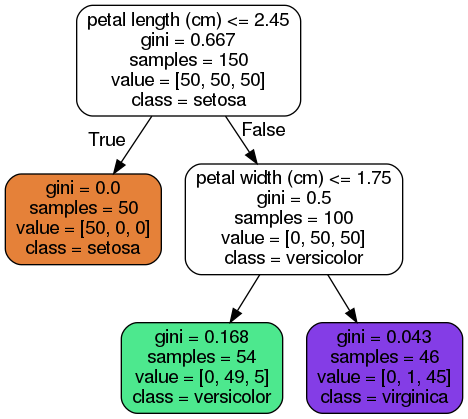

In [107]:
# load iris data
from sklearn.datasets import load_iris

iris = load_iris()
x = iris['data']
y = iris['target']

my_clf = MyDecisionTreeClassifier(max_depth=2)#min_samples_split=2)
clf = DecisionTreeClassifier(max_depth=2)#min_samples_split=2)

my_clf.fit(x, y)
clf.fit(x, y)

dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=iris.feature_names,
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

graph = graph_from_dot_data(dot_data)
graph.write_png('sk_tree_iris.png')

print('Tree: ')
print(my_clf.tree_)

x_test = np.array([[1.3, 3.6, 3.4, 2.4]])
print('Predict probas (my): ', my_clf.predict_proba(x_test))
print('Predict_probas (sklearn): ', clf.predict_proba(x_test))

Image(filename='sk_tree_iris.png', width=600) 

На основе результатов, можно увидеть следующее:
- При определенном random_state, данные по построению дерева и предсказанию равны, кроме точки разбиения petal width (cm)
    - В нашей реализации, точка разбиения равна 1.7
    - В реализации sklearn, точка разбиения равна 1.75  

Посмотрим на отсортированный данный признак и соответствующие ему классы

In [86]:
sorted_x, sorted_y = my_clf._sort_samples(x, y, 3)
np.c_[sorted_x[:, 3], sorted_y]

array([[ 0.1,  0. ],
       [ 0.1,  0. ],
       [ 0.1,  0. ],
       [ 0.1,  0. ],
       [ 0.1,  0. ],
       [ 0.1,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.2,  0. ],
       [ 0.3,  0. ],
       [ 0.3,  0. ],
       [ 0.3,  0. ],
       [ 0.3,  0. ],
       [ 0.3,  0. ],
       [ 0.3,  0. ],
       [ 0.3,  0. ],
       [ 0.4,  0. ],
       [ 0.4,  0. ],
       [ 0.4,  0. ],
       [ 0.4,  0. ],
       [ 0.4,  0. ],
       [ 0.4,  0. ],
       [ 0.4,

- Можно заметить, что для значения данного признака 1.7, есть 2 объекта с разными классами (2 и 1).  
Соответственно, данная точка разбиения в нашей реализации найдена корректна (относительно поставленной задачи), и sklearn в таких случаях использует какой-то другой алгоритм выбора точки разбиения.  
Возможно, sklearn использует в таких случаях среднее между данным значением признака и следующим уникальным, то есть между 1.7 и 1.8, и таким образом получает точку разбиения 1.75), но это требует дополнительного исследования
- В таких же случаях (одному значению признака соответствуют разные классы в разных объектах) возникают дополнительные проблемы, которые обрабатываются в коде
    - Появляются дубли значений точек разбиения для признака, т.к. для одного и того же значения признака (после сортировки) класс может меняться несколько раз.  
    Для обработки такой ситуации, при рассчете всех точек разбиения, удаляются дубли значений (для ускорения работы)
    - Если такая ситуация случается для первой или последней точки разбиения, то при разбиении одна из групп разбиения может быть пустой.  
    Для обработки такой ситуации, при рассчете Information Gain проверяется значения записей в группах разбиений, если группа пустая, считаем значение criterion для пустой группы равным 0, что кажется логичным, т.к. при таком разбиении IG не изменяется. Таким образом мы также избавляемся от ошибки деления на 0 при расчете в методе _get_probs()

Загрузим данные iris, и сравним точность работы 2 классификаторов (реализованного и из sklearn)
Сначала сравним классификаторы для max_depth=2

Tree: 
{0: (0, 2, 2.4500000000000002), 1: (1, 0, array([ 1.,  0.,  0.])), 2: (0, 3, 1.7), 5: (0, 2, 4.9500000000000002), 11: (0, 3, 1.6499999999999999), 23: (1, 1, array([ 0.,  1.,  0.])), 24: (1, 2, array([ 0.,  0.,  1.])), 12: (0, 3, 1.55), 25: (1, 2, array([ 0.,  0.,  1.])), 26: (0, 0, 6.9500000000000002), 53: (1, 1, array([ 0.,  1.,  0.])), 54: (1, 2, array([ 0.,  0.,  1.])), 6: (0, 2, 4.7999999999999998), 13: (0, 0, 5.9500000000000002), 27: (1, 1, array([ 0.,  1.,  0.])), 28: (1, 2, array([ 0.,  0.,  1.])), 14: (1, 2, array([ 0.,  0.,  1.]))}
Predict probas (my):  [[ 0.  1.  0.]]
Predict_probas (sklearn):  [[ 0.  1.  0.]]


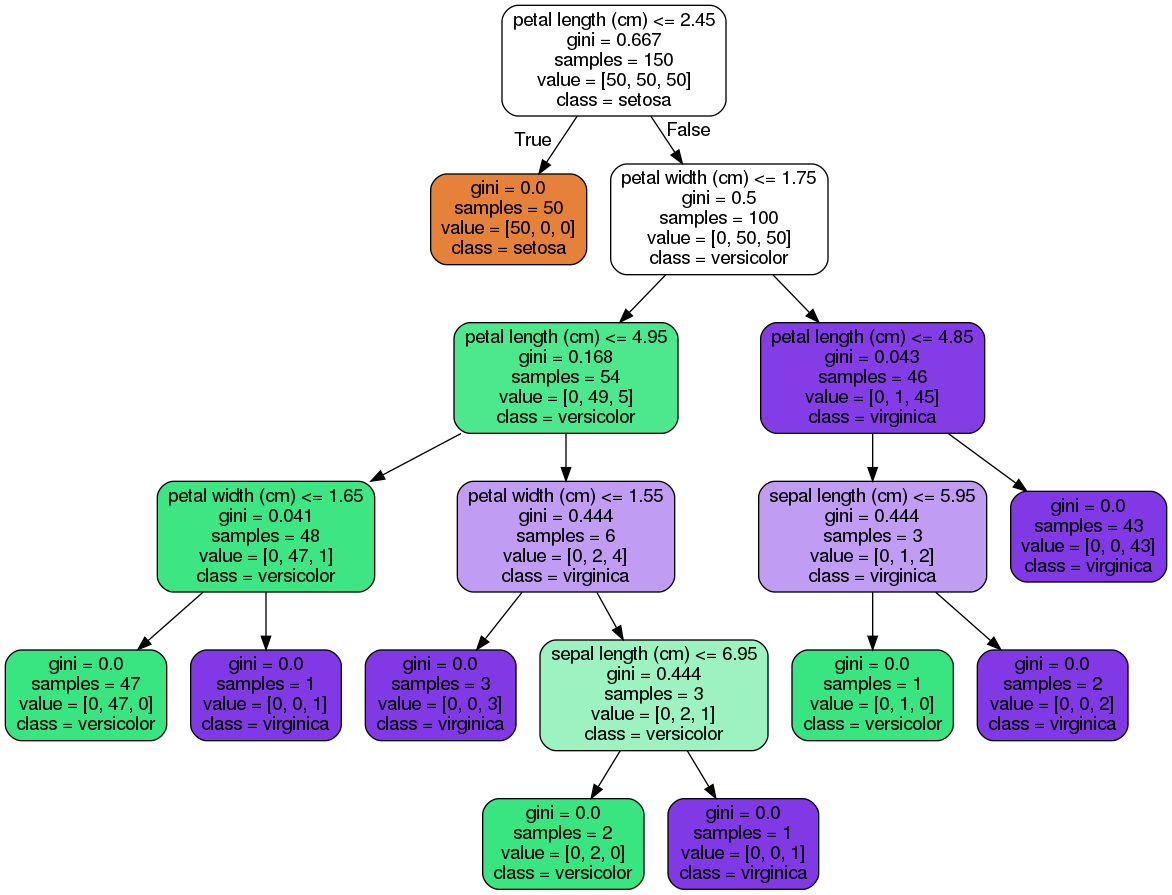

In [91]:
my_clf = MyDecisionTreeClassifier(criterion='gini', min_samples_split=2)
clf = DecisionTreeClassifier(criterion='gini', min_samples_split=2)

my_clf.fit(x, y)
clf.fit(x, y)

dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=iris.feature_names,
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

graph = graph_from_dot_data(dot_data)
graph.write_png('sk_tree_iris.png')

print('Tree: ')
print(my_clf.tree_)

x_test = np.array([[1.3, 3.6, 3.4, 2.4]])
print('Predict probas (my): ', my_clf.predict_proba(x_test))
print('Predict_probas (sklearn): ', clf.predict_proba(x_test))

Image(filename='sk_tree_iris.png', width=1000) 

На основе результатов, можно сделать следующие выводы:
- При определенном значении random_state, результаты реализации sklearn совпадают с нашей реализацией, кроме значения точки разбиения "petal length (cm) <= 4.85" (в нашей реализации - значение 4.8)
- На основе предыдущих запусков, сделаем, предположение, что причина та же - для данного признака есть несколько объектов со значением 4.8, но с разными классами, и следующим значением является 4.9, и возможно поэтому sklearn рассчитал значения признака 4.85  

Проверим наше предположение

In [92]:
sorted_x, sorted_y = my_clf._sort_samples(x, y, 2)
np.c_[sorted_x[:, 2], sorted_y]

array([[ 1. ,  0. ],
       [ 1.1,  0. ],
       [ 1.2,  0. ],
       [ 1.2,  0. ],
       [ 1.3,  0. ],
       [ 1.3,  0. ],
       [ 1.3,  0. ],
       [ 1.3,  0. ],
       [ 1.3,  0. ],
       [ 1.3,  0. ],
       [ 1.3,  0. ],
       [ 1.4,  0. ],
       [ 1.4,  0. ],
       [ 1.4,  0. ],
       [ 1.4,  0. ],
       [ 1.4,  0. ],
       [ 1.4,  0. ],
       [ 1.4,  0. ],
       [ 1.4,  0. ],
       [ 1.4,  0. ],
       [ 1.4,  0. ],
       [ 1.4,  0. ],
       [ 1.4,  0. ],
       [ 1.5,  0. ],
       [ 1.5,  0. ],
       [ 1.5,  0. ],
       [ 1.5,  0. ],
       [ 1.5,  0. ],
       [ 1.5,  0. ],
       [ 1.5,  0. ],
       [ 1.5,  0. ],
       [ 1.5,  0. ],
       [ 1.5,  0. ],
       [ 1.5,  0. ],
       [ 1.5,  0. ],
       [ 1.5,  0. ],
       [ 1.5,  0. ],
       [ 1.6,  0. ],
       [ 1.6,  0. ],
       [ 1.6,  0. ],
       [ 1.6,  0. ],
       [ 1.6,  0. ],
       [ 1.6,  0. ],
       [ 1.6,  0. ],
       [ 1.7,  0. ],
       [ 1.7,  0. ],
       [ 1.7,  0. ],
       [ 1.7,

Таким образом, наше предположение оправдалось, и наше разбиение было корректным относительно поставленной задачи

## Проверка скорости работы

Сравним скорость работы 2 классификаторов, используя оригинальный код, и %timeit для рассчета mean и std на основе нескольких запусков (для получения более стабильной оценки)

Оригинальный код

In [93]:
t1 = time()
my_clf.fit(x, y)
t2 = time()
print(t2 - t1)

t1 = time()
clf.fit(x, y)
t2 = time()
print(t2 - t1)

0.014562129974365234
0.0011682510375976562


Использование %timeit

In [94]:
my_clf_time = %timeit -o my_clf.fit(x, y)

11 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [95]:
clf_time = %timeit -o clf.fit(x, y)

275 µs ± 34.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Рассчитаем, насколько медленнее работает наша реализация

In [96]:
my_clf_time.average / clf_time.average

39.87611960857236

**Возможные способы уменьшения времени работы нашей реализации**
- По возможности, избавиться от пограничных точек разбиения, в результате которых одна из групп разбиения пустая
- Сделать векторную реализацию 2 вложенных циклов for (по признакам и точкам разбиения)
- Сделать параллелизацию 
    - Поиска точек разбиения
        - По признакам
        - По возможным точкам разбиения
    - Расчета отдельных групп разбиения и рекурсивного построения отдельных ветвей

## Проверка качества работы

In [97]:
gkf = KFold(n_splits=5, shuffle=True)

In [108]:
for train, test in gkf.split(x, y):
    X_train, y_train = x[train], y[train]
    X_test, y_test = x[test], y[test]
    my_clf.fit(X_train, y_train)
    print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))

0.966666666667
0.966666666667
0.966666666667
0.9
1.0


In [109]:
for train, test in gkf.split(x, y):
    X_train, y_train = x[train], y[train]
    X_test, y_test = x[test], y[test]
    clf.fit(X_train, y_train)
    print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))

0.966666666667
1.0
0.866666666667
0.933333333333
0.9


Можно заметить, что по метрике accuracy наша реализация сравнима с реализацией из sklearn

# Применить для задачи Titanic 

Для проверки, используем последнюю версии трансформации данных по задаче Titanic, и используем GridSearchCV для сравнения работы 2 классификаторов

In [110]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, CategoricalEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

from pandas import Series, DataFrame

import warnings
warnings.filterwarnings("ignore")

In [111]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [112]:
train_df = train_data.copy()
test_df = test_data.copy()

In [113]:
X = train_df.drop('Survived', axis=1).copy()
y = train_df['Survived'].copy()

X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [114]:
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [115]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, label=None):
        self.label = label
    
    def fit(self, X, y=None):
        if self.label:
            self.fill_values_ = self.label 
        else:
            self.fill_values_ = X.mode().iloc[0]
        return self
    
    def transform(self, X):
        return X.fillna(self.fill_values_).values

In [116]:
class NumericBinner(BaseEstimator, TransformerMixin):
    def __init__(self, bins):
        self.bins = bins
    
    def fit(self, X, y=None):
        self.bin_ranges_ = pd.cut(X, self.bins, labels=False, retbins=True)
        return self
    
    def transform(self, X):
        X_bin = pd.cut(X, self.bin_ranges_, labels=False, include_lowest=True)
        return X_bin

In [117]:
class ColumnSummator(BaseEstimator, TransformerMixin):
    def __init__(self, const=0):
        self.const = const
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_sum = X.sum(axis=1).reshape(-1, 1) + self.const
        return X_sum

In [118]:
class TitleExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, title_names):
        self.title_names = title_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.core.frame.DataFrame):
            X_ser = Series(X.values.ravel())
        elif isinstance(X, np.ndarray):
            X_ser = Series(X.ravel())
            
        titles = X_ser.str.extract('\s+(\w+)\.\s+')
        bin_titles = np.where(titles.isin(self.title_names), titles, 'Rare').reshape(-1, 1)
        
        return bin_titles

In [119]:
class FullInfoChecker(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        full_info = DataFrame(X).notnull().all(axis=1).astype(int).values.reshape(-1, 1)
        return full_info

In [120]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('pclass', Pipeline([
            ('extract', ColumnExtractor(columns=['Pclass']))
        ])),
        ('sex', Pipeline([
            ('extract', ColumnExtractor(columns=['Sex'])),
            ('to_ordered_cat', CategoricalEncoder(encoding='ordinal'))
        ])),
        ('embarked', Pipeline([
            ('extract', ColumnExtractor(columns=['Embarked'])),
            ('impute', CategoricalImputer()),
            ('to_ohe_cat', CategoricalEncoder('onehot-dense'))
        ])),
        ('age', Pipeline([
            ('extract', ColumnExtractor(columns=['Age'])),
            ('impute', SimpleImputer(strategy='mean')),
            ('normalize', StandardScaler()),
        ])),
        ('fare', Pipeline([
            ('extract', ColumnExtractor(columns=['Fare'])),
            ('impute', SimpleImputer(strategy='mean')),
            ('normalize', StandardScaler()),
        ])),
        ('title', Pipeline([
            ('extract', ColumnExtractor(columns=['Name'])),
            ('get_feature', TitleExtractor(title_names=['Mr', 'Miss', 'Mrs', 'Master'])),
            ('to_ohe_cat', CategoricalEncoder('onehot-dense'))
        ])),
        ('family_size', Pipeline([
            ('extract', ColumnExtractor(columns=['SibSp', 'Parch'])),
            ('sum', ColumnSummator(const=1))
        ])),
        ('full_info', Pipeline([
            ('get_feature', FullInfoChecker())
        ]))
    ])),
    ('clf', DecisionTreeClassifier())
])

In [121]:
param_grid = {'clf': [DecisionTreeClassifier()],
              'clf__criterion': ['gini', 'entropy'],
              'clf__max_depth': [2, 4, 6],
              'clf__min_samples_split': [2, 4, 6]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
grid_search.fit(X, y)
grid_search.best_params_, grid_search.best_score_

({'clf': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best'),
  'clf__criterion': 'gini',
  'clf__max_depth': 4,
  'clf__min_samples_split': 2},
 0.83613916947250277)

In [122]:
my_param_grid = {'clf': [MyDecisionTreeClassifier()],
                 'clf__criterion': ['gini', 'entropy', 'misclass'],
                 'clf__max_depth': [2, 4, 6],
                 'clf__min_samples_split': [2, 4, 6]}

my_grid_search = GridSearchCV(pipeline, param_grid=my_param_grid, scoring='accuracy', cv=10, n_jobs=-1)
my_grid_search.fit(X, y)
my_grid_search.best_params_, my_grid_search.best_score_

({'clf': MyDecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_split=2),
  'clf__criterion': 'gini',
  'clf__max_depth': 4,
  'clf__min_samples_split': 2},
 0.83838383838383834)

Таким образом, можно сделать вывод, что на данном датасете качество 2 классификаторов примерно одинаковое, но так как оно ниже, чем на кросс-валидации при решении задачи Titanic (примерно 0.841751), предсказания для kaggle не производились

**Замечание**  
При указании большого значения max_depth (или без его указания) при малом значении min_samples_split, происходит превышении глубины рекурсии (RecursionError: maximum recursion depth exceeded in comparison).  
По умолчанию лимит равен 3000.

In [123]:
import sys
sys.getrecursionlimit()

3000

In [ ]:
# Code to reproduce the error
my_param_grid = {'clf': [MyDecisionTreeClassifier()],
                 'clf__criterion': ['gini'],
                 'clf__min_samples_split': [2]}

my_grid_search = GridSearchCV(pipeline, param_grid=my_param_grid, scoring='accuracy', cv=10, n_jobs=-1)
my_grid_search.fit(X, y)
my_grid_search.best_params_, my_grid_search.best_score_

Т.к. реализация в нашем случае - рекурсивная, то для работы с большей глубиной дальнейшие улучшения могут быть следующие:
- Увеличение глубины рекурсии (с помощью sys.setrecursionlimit()) - не рекомендуется
- Если проблема именно в большой глубине дерева - то необходимо рассмотреть возможность реализации алгоритма или другим способом (например, рассмотреть возможность реализации по статье http://blog.moertel.com/posts/2013-05-11-recursive-to-iterative.html), или исследовать вариант реализации на cython, как у реализации из sklearn (если это cможет помочь)
- Возможно, это проблема текущего алгоритма поиска сплита, и надо исследовать ситуацию, когда на одно значение признака много объектов с разными классами, и при текущей реализации, уменьшить размер группы разбиения до min_samples_split не удается. В таком случае, нужно рассмотреть другие варианты реализации поиска сплита.